In [1]:
# 1) Design model (input size, output size, forward pass)
# 2) Construct loss and optimizer
# 3) Training loop
#    - forward pass: compute prediction and loss
#    - backward pass: gradients
#    - update weights


# SIFAR-10
# DataLoader, Transformation
# Multilayer Neural Net, activation function
# Loss and Optimizer
# Training Loop (batch training)
# Model evaluation
# GPU support

# ENV: Python 3.9.12

In [2]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision # some builtin datasets
from torchvision import transforms, datasets, models

import math
import time
import copy
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Settings

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# hyper parameters
num_epoches = 20
batch_size = 10
learning_rate = 0.001

# for normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

device: cuda


In [6]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
        ]),
    'val':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
        ])
}

# import data
data_dir = "./data/hymenoptera"
sets = ['train', 'val']
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                            data_transforms[x])
    for x in sets
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], 
                                   batch_size=4,
                                   shuffle=True,
                                   num_workers=0)
    for x in sets
}

dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 3, 224, 224]) torch.Size([4])


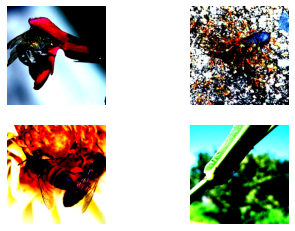

In [7]:
examples = iter(dataloaders['train'])
samples, labels = examples.next()
print(samples.shape, labels.shape)

examples = iter(dataloaders['val'])
samples, labels = examples.next()
print(samples.shape, labels.shape)

for i in range(4):
    plt.subplot(2, 2, i+1)
    img = samples[i].permute(1, 2, 0) #change from C, H, W to H, W, C.
    plt.imshow(img) 
    plt.axis("off")
plt.show()

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epoches=10):
    # Learning rate scheduling should be applied after optimizer's update
    # e.g.,
    # for epoch in range(100):
    #   train()
    #   validate()
    #   scheduler.step()
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epoches):
        print('Epoch {}/{}'.format(epoch, num_epoches - 1))
        print("-"*10)

        for phase in sets:
            if phase == "train":
                model.train() #set model to be the training model
            else:
                model.eval() #set model to be in the evaluation model

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase == "train"):
                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                    #statistics
                    running_loss += loss.item()*inputs.shape[0]
                    running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed//60, time_elapsed%60
    ))
    print('Best val acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
# Method 1: Fune Tuning
# Load a pretrained model and reset final fully connected layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# StepLR decays the learning rate by a factor of 0.1 every 7 epochs

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epoches=5)

Epoch 0/4
----------
train Loss: 0.7226 Acc: 0.5451
val Loss: 0.5033 Acc: 0.7778

Epoch 1/4
----------
train Loss: 0.5332 Acc: 0.7582
val Loss: 0.3597 Acc: 0.8954

Epoch 2/4
----------
train Loss: 0.4789 Acc: 0.7951
val Loss: 0.3055 Acc: 0.9216

Epoch 3/4
----------
train Loss: 0.3853 Acc: 0.8484
val Loss: 0.2582 Acc: 0.9412

Epoch 4/4
----------
train Loss: 0.3757 Acc: 0.8566
val Loss: 0.2256 Acc: 0.9477

Training complete in 0m 10s
Best val acc: 0.9477


In [16]:
# Method 2: 
# Freeze all the network except the final layer.
# Set requires_grad == False to free the parameters so that the gradients are not
# computed in backward
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad = True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epoches=5)

Epoch 0/4
----------
train Loss: 0.5593 Acc: 0.6967
val Loss: 0.2332 Acc: 0.9346

Epoch 1/4
----------
train Loss: 0.5298 Acc: 0.7418
val Loss: 0.1767 Acc: 0.9673

Epoch 2/4
----------
train Loss: 0.4479 Acc: 0.7910
val Loss: 0.2555 Acc: 0.9020

Epoch 3/4
----------
train Loss: 0.6596 Acc: 0.7172
val Loss: 0.2414 Acc: 0.9216

Epoch 4/4
----------
train Loss: 0.3062 Acc: 0.8893
val Loss: 0.2028 Acc: 0.9412

Training complete in 0m 8s
Best val acc: 0.9673
